# TC3006B
## Deep Learning
# Script para elegir 300 imágenes al azar del bucket de s3 y obtener su meta-data

### Preparations for the script
You need to install the aws cli in order for the script to work: https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html

Once installed, run the command 

*aws configure*

It will ask you for some keys that are hidden for security purposes. For the region put us-east-1 and for output leave it as default "json".

And for the libraries just run 

*pip install -r requirements.txt*

If everything is configured correctly you may run now the script.

## Creación del csv

### Imports

In [57]:
import boto3
import csv
import random
from io import BytesIO
from PIL import Image, ImageStat
from concurrent.futures import ThreadPoolExecutor, as_completed

### Variables globales

In [58]:
# Configuración
BUCKET_NAME = 'caetec-vacas'  # Reemplaza con tu nombre de bucket
OUTPUT_CSV = 's3_image_metadata_advanced_with_histograms.csv'
MAX_IMAGES = 3000  # Número máximo de imágenes a procesar
MAX_WORKERS = 10  # Número de hilos para procesamiento paralelo

### Creamos una lista con todos los objetos de la bucket

In [59]:
def list_all_objects(s3_client, bucket):
    paginator = s3_client.get_paginator('list_objects_v2')
    page_iterator = paginator.paginate(Bucket=bucket)
    all_objects = []
    for page in page_iterator:
        contents = page.get('Contents', [])
        all_objects.extend(contents)
    return all_objects

### Procesamos cada imagen obteniendo la meta-data de la misma, witdh, height, luminosity, contrast e histogramas rgb

In [60]:
def process_object(s3_client, bucket, obj):
    key = obj['Key']
    last_modified = obj['LastModified']
    size = obj['Size']
    etag = obj['ETag']
    storage_class = obj.get('StorageClass', 'STANDARD')
    owner = obj.get('Owner', {}).get('DisplayName', 'Unknown')
    content_type = obj.get('ContentType', 'Unknown')
    
    # Inicializar variables para características avanzadas
    width, height = None, None
    luminosity, contrast = None, None
    histogram_red, histogram_green, histogram_blue = [None]*256, [None]*256, [None]*256
    
    try:
        # Descargar la imagen en memoria
        response = s3_client.get_object(Bucket=bucket, Key=key)
        image_data = response['Body'].read()
        image = Image.open(BytesIO(image_data)).convert('RGB')  # Asegurar que la imagen esté en RGB
        
        # Obtener dimensiones de la imagen
        width, height = image.size
        
        # Convertir la imagen a escala de grises para calcular luminosidad y contraste
        grayscale_image = image.convert('L')
        stat = ImageStat.Stat(grayscale_image)
        
        # Calcular la luminosidad (media de los valores de píxel)
        luminosity = stat.mean[0]
        
        # Calcular el contraste (desviación estándar de los valores de píxel)
        contrast = stat.stddev[0]
        
        # Calcular histogramas para cada canal
        histogram = image.histogram()
        # Histograma tiene 256 valores por canal (R, G, B)
        histogram_red = histogram[0:256]
        histogram_green = histogram[256:512]
        histogram_blue = histogram[512:768]
        
    except Exception as e:
        print(f"Error procesando {key}: {e}")
        # Asignar valores predeterminados o continuar según sea necesario
        width, height = None, None
        luminosity, contrast = None, None
        histogram_red, histogram_green, histogram_blue = [None]*256, [None]*256, [None]*256
    
    # Preparar los histogramas como cadenas de texto
    histogram_red_str = ';'.join(map(str, histogram_red)) if histogram_red else ''
    histogram_green_str = ';'.join(map(str, histogram_green)) if histogram_green else ''
    histogram_blue_str = ';'.join(map(str, histogram_blue)) if histogram_blue else ''
    
    Url = f"https://{bucket}.s3.amazonaws.com/{key}"
    
    return [
        key, Url, last_modified, size, etag, 
        storage_class, owner, content_type,
        width, height, luminosity, contrast,
        histogram_red_str, histogram_green_str, histogram_blue_str
    ]

### Creamos la funcion main y escribimos en el meta-data

In [61]:
def main():
    # Inicializar el cliente de S3
    s3 = boto3.client('s3')
    
    # Listar todos los objetos en el bucket
    print("Listando objetos en el bucket...")
    all_objects = list_all_objects(s3, BUCKET_NAME)
    total_objects = len(all_objects)
    print(f"Total de objetos en el bucket: {total_objects}")
    
    if total_objects == 0:
        print("No se encontraron objetos en el bucket.")
        return
    
    # Elegir 300 objetos al azar si hay suficientes, si no, toma todos
    sample_size = min(total_objects, MAX_IMAGES)
    sampled_objects = random.sample(all_objects, sample_size)
    print(f"Seleccionando {sample_size} objetos al azar para procesar...")
    
    # Definir los encabezados del CSV
    headers = [
        'Key', 'Url', 'LastModified', 'Size', 'ETag', 
        'StorageClass', 'Owner', 'ContentType',
        'Width', 'Height', 'Luminosity', 'Contrast',
        'Histogram_Red', 'Histogram_Green', 'Histogram_Blue'
    ]
    
    # Procesar los objetos en paralelo para mejorar el rendimiento
    print("Procesando objetos y extrayendo metadata...")
    processed_data = []
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # Enviar tareas al pool de hilos
        futures = {executor.submit(process_object, s3, BUCKET_NAME, obj): obj for obj in sampled_objects}
        for future in as_completed(futures):
            data = future.result()
            processed_data.append(data)
    
    # Escribir los datos en el CSV
    print(f"Escribiendo metadata en el archivo CSV: {OUTPUT_CSV}")
    with open(OUTPUT_CSV, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(headers)  # Escribir encabezados
        writer.writerows(processed_data)  # Escribir filas de datos
    
    print(f"CSV creado con {sample_size} registros de metadata avanzados seleccionados al azar.")


### Corremos el programa

In [62]:
if __name__ == "__main__":
    main()

Listando objetos en el bucket...
Total de objetos en el bucket: 2189
Seleccionando 2189 objetos al azar para procesar...
Procesando objetos y extrayendo metadata...
Error procesando train/: cannot identify image file <_io.BytesIO object at 0x7fe18ad4efc0>
Escribiendo metadata en el archivo CSV: s3_image_metadata_advanced_with_histograms.csv
CSV creado con 2189 registros de metadata avanzados seleccionados al azar.


## Creamos gráficas para visualización de la información en el csv

### Imports

In [68]:
# Importar las bibliotecas necesarias
import pandas as pd
import seaborn as sns
from PIL import Image

# Configurar estilos para las gráficas
sns.set(style="whitegrid")
%matplotlib inline


### Pasamor el csv a pandas

In [69]:
# Cargar el CSV en un DataFrame de pandas
df = pd.read_csv('s3_image_metadata_advanced_with_histograms.csv')


### Visualizamos csv

In [70]:
df

,Key,Url,LastModified,Size,ETag,StorageClass,Owner,ContentType,Width,Height,Luminosity,Contrast,Histogram_Red,Histogram_Green,Histogram_Blue
0,test/1/2024-04-27-18-35-03_jpg.rf.96491ad92bf7...,https://caetec-vacas.s3.amazonaws.com/test/1/2...,2024-10-14 18:27:35+00:00,235338,"""028009399352d39e5a3d6e08e9126fb6""",STANDARD,Unknown,Unknown,1920,1080,81.937440,34.016746,0;0;0;0;0;1;3;2;8;3;16;27;30;56;77;136;214;247...,0;0;1;0;0;6;5;9;22;16;38;47;95;120;172;283;462...,450;231;311;507;761;1087;1687;2289;2909;3836;4...
1,validation/3/2024-05-18-05-05-03_jpg.rf.9cafd0...,https://caetec-vacas.s3.amazonaws.com/validati...,2024-10-14 18:17:46+00:00,27217,"""5dd3b90480e2ba6b07731f485975c55b""",STANDARD,Unknown,Unknown,640,640,10.300159,16.746240,60103;71639;27148;21522;14716;11944;10577;1014...,72419;83958;37361;24593;19680;17121;15045;1255...,135799;89347;38338;26485;20648;16139;12315;986...
2,validation/6/2024-05-17-07-55-03_jpg.rf.192f4f...,https://caetec-vacas.s3.amazonaws.com/validati...,2024-10-14 18:15:38+00:00,56117,"""2a0f0fd3f3b915639dad8c18804bf844""",STANDARD,Unknown,Unknown,640,640,132.929751,68.434606,0;0;0;0;0;0;0;0;0;0;0;0;0;0;1;3;6;16;37;43;70;...,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;1;3;8;17;39;...,0;0;0;0;0;0;0;0;0;0;0;0;0;2;2;5;8;14;26;44;77;...
3,validation/4/2024-05-18-19-30-02_jpg.rf.bba085...,https://caetec-vacas.s3.amazonaws.com/validati...,2024-10-14 18:17:14+00:00,44803,"""5fb0f4c9dc435b3fca7bb10569522a23""",STANDARD,Unknown,Unknown,640,640,41.098159,39.395516,12;12;43;91;223;311;449;671;1061;1508;1840;257...,74;133;278;645;1034;1829;2962;4264;6019;7112;8...,8288;5777;8788;12992;17148;21273;23807;23918;2...
4,test/3/2024-04-27-17-30-03_jpg.rf.8b7a88c80b4f...,https://caetec-vacas.s3.amazonaws.com/test/3/2...,2024-10-14 18:24:42+00:00,260135,"""35c12ec4d58b2321ccc315f8e2dbede7""",STANDARD,Unknown,Unknown,1920,1080,127.103539,59.462062,0;0;0;0;0;0;0;0;0;0;0;0;0;0;1;0;0;1;12;15;26;2...,0;1;2;0;1;2;11;16;25;59;165;251;407;866;1321;2...,2162;869;1338;1890;2677;3687;5120;6705;8412;10...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2183,train/2/2024-05-19-22-15-03_jpg.rf.9828a05f22e...,https://caetec-vacas.s3.amazonaws.com/train/2/...,2024-10-14 18:08:09+00:00,128606,"""a7031990d00d3af1b57998b2b858e33f""",STANDARD,Unknown,Unknown,1920,1080,9.931062,11.527252,153174;218312;155016;95664;70846;63035;57948;5...,284583;310403;180699;128923;105415;92872;81706...,583486;407130;235349;184397;152778;124213;9704...
2184,validation/5/2024-05-17-04-15-03_jpg.rf.3ac589...,https://caetec-vacas.s3.amazonaws.com/validati...,2024-10-14 18:16:08+00:00,28835,"""3216dab91721b8617736a77120333c0d""",STANDARD,Unknown,Unknown,640,640,14.108086,19.590158,2256;14385;56297;32749;18248;17551;15388;13165...,58638;55558;45444;27239;18955;14029;10950;9221...,116153;74415;42803;34185;28639;21078;14917;103...
2185,test/4/2024-05-02-23-50-03_jpg.rf.16d09bc501ad...,https://caetec-vacas.s3.amazonaws.com/test/4/2...,2024-10-14 18:24:02+00:00,123848,"""42aea2b777cf1dc3c0a5cac3f390eeab""",STANDARD,Unknown,Unknown,1920,1080,13.804748,18.894474,85641;197758;176541;122709;84291;68133;58921;5...,205854;306542;193582;130267;99520;87295;77040;...,545578;368131;210563;166546;138011;115705;9280...
2186,train/6/2024-05-20-11-35-03_jpg.rf.845a20e6268...,https://caetec-vacas.s3.amazonaws.com/train/6/...,2024-10-14 18:30:24+00:00,171234,"""aaf00b2b9d057a2882f2218af91effba""",STANDARD,Unknown,Unknown,1920,1080,135.334741,62.946940,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;2;...,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;...,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;...


### Convertimos la cadena de histogramas en strings a int

In [71]:
# Definir una función para convertir la cadena de histograma en una lista de enteros
def histogram_str_to_list(hist_str):
    if pd.isna(hist_str) or hist_str == '':
        return [0]*256
    return list(map(int, hist_str.split(';')))

# Aplicar la función a las columnas de histogramas
df['Histogram_Red'] = df['Histogram_Red'].apply(histogram_str_to_list)
df['Histogram_Green'] = df['Histogram_Green'].apply(histogram_str_to_list)
df['Histogram_Blue'] = df['Histogram_Blue'].apply(histogram_str_to_list)

# Verificar la conversión
df[['Histogram_Red', 'Histogram_Green', 'Histogram_Blue']].head()


,Histogram_Red,Histogram_Green,Histogram_Blue
0,"[0, 0, 0, 0, 0, 1, 3, 2, 8, 3, 16, 27, 30, 56,...","[0, 0, 1, 0, 0, 6, 5, 9, 22, 16, 38, 47, 95, 1...","[450, 231, 311, 507, 761, 1087, 1687, 2289, 29..."
1,"[60103, 71639, 27148, 21522, 14716, 11944, 105...","[72419, 83958, 37361, 24593, 19680, 17121, 150...","[135799, 89347, 38338, 26485, 20648, 16139, 12..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, ..."
3,"[12, 12, 43, 91, 223, 311, 449, 671, 1061, 150...","[74, 133, 278, 645, 1034, 1829, 2962, 4264, 60...","[8288, 5777, 8788, 12992, 17148, 21273, 23807,..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 1, 2, 0, 1, 2, 11, 16, 25, 59, 165, 251, 4...","[2162, 869, 1338, 1890, 2677, 3687, 5120, 6705..."


### Seleccionamos una imagen al azar y ploteamos los histogramas con la intensidad de rgb

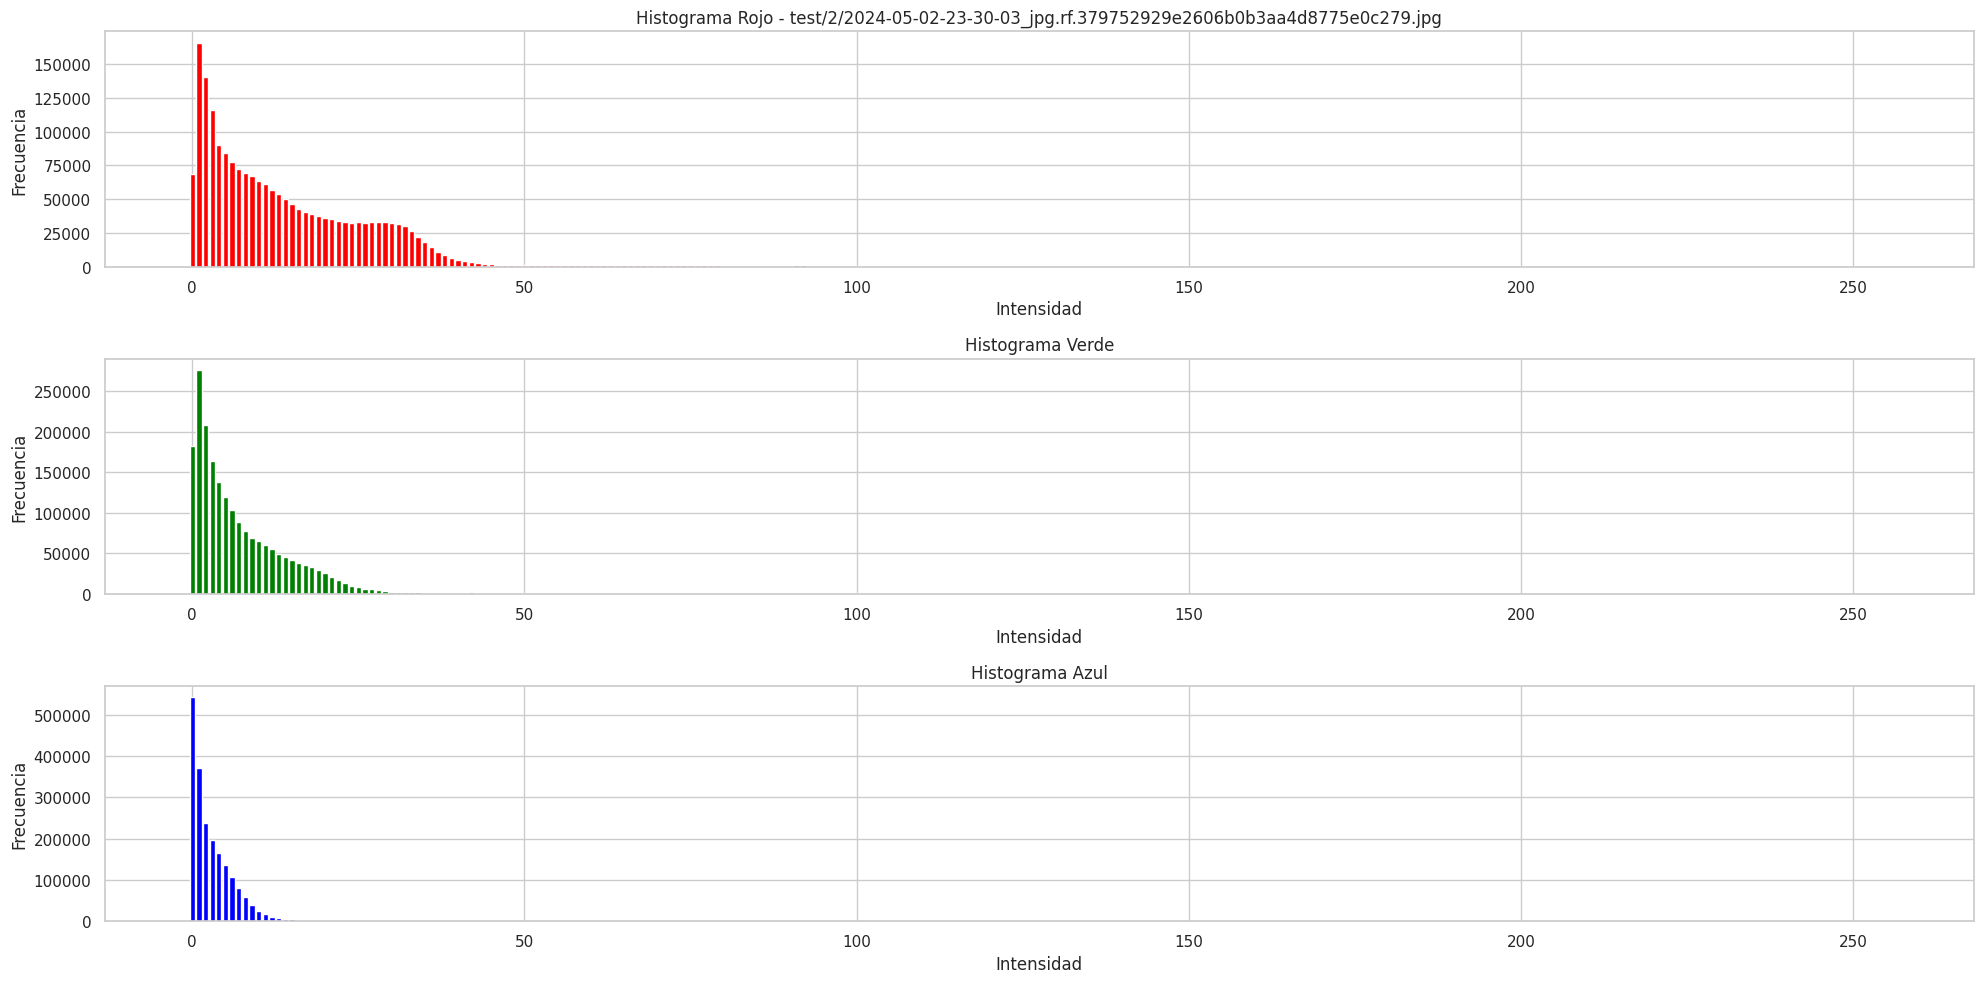

In [72]:
import random
import matplotlib.pyplot as plt

# Seleccionar una imagen al azar
random_index = random.randint(0, len(df)-1)
image_row = df.iloc[random_index]

# Extraer los histogramas
hist_red = image_row['Histogram_Red']
hist_green = image_row['Histogram_Green']
hist_blue = image_row['Histogram_Blue']

# Crear los histogramas
plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)  # 3 filas, 1 columna, primer subplot
plt.bar(range(256), hist_red, color='red')
plt.title(f"Histograma Rojo - {image_row['Key']}")
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')

plt.subplot(3, 1, 2)  # 3 filas, 1 columna, segundo subplot
plt.bar(range(256), hist_green, color='green')
plt.title("Histograma Verde")
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')

plt.subplot(3, 1, 3)  # 3 filas, 1 columna, tercer subplot
plt.bar(range(256), hist_blue, color='blue')
plt.title("Histograma Azul")
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


### Sobreponemos los 3 histogramas

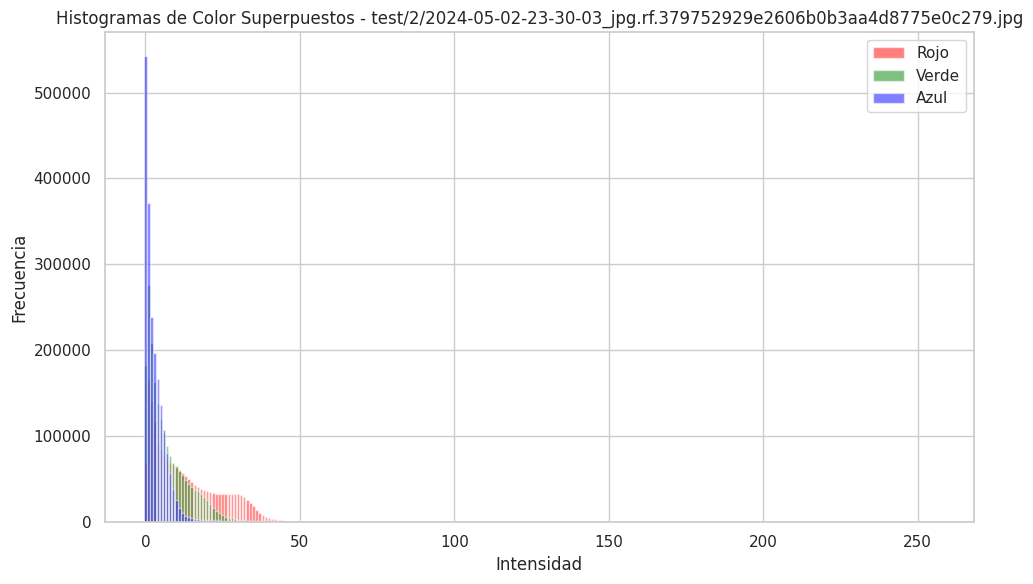

In [73]:
import matplotlib.pyplot as plt

# Crear una sola gráfica con los tres histogramas superpuestos
plt.figure(figsize=(10, 6))

plt.bar(range(256), hist_red, color='red', alpha=0.5, label='Rojo')
plt.bar(range(256), hist_green, color='green', alpha=0.5, label='Verde')
plt.bar(range(256), hist_blue, color='blue', alpha=0.5, label='Azul')

plt.title(f"Histogramas de Color Superpuestos - {image_row['Key']}")
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')
plt.legend()

plt.tight_layout()
plt.show()


### Creamos el histograma promedio de todo el dataset 

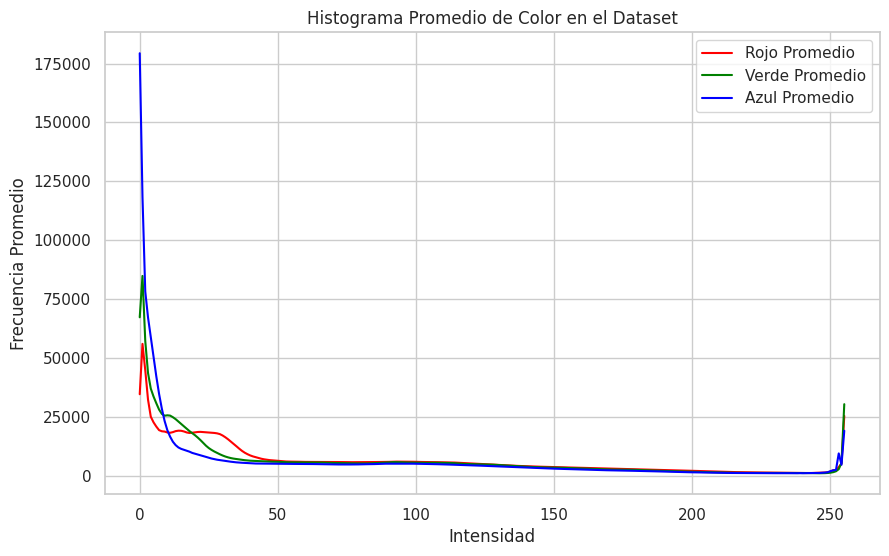

In [74]:
import numpy as np

# Inicializar arrays para acumular los histogramas
accum_hist_red = np.zeros(256)
accum_hist_green = np.zeros(256)
accum_hist_blue = np.zeros(256)

# Acumular los histogramas de todas las imágenes
for idx, row in df.iterrows():
    accum_hist_red += np.array(row['Histogram_Red'])
    accum_hist_green += np.array(row['Histogram_Green'])
    accum_hist_blue += np.array(row['Histogram_Blue'])

# Calcular los histogramas promedio
num_images = len(df)
avg_hist_red = accum_hist_red / num_images
avg_hist_green = accum_hist_green / num_images
avg_hist_blue = accum_hist_blue / num_images

# Graficar los histogramas promedio
plt.figure(figsize=(10, 6))
plt.plot(range(256), avg_hist_red, color='red', label='Rojo Promedio')
plt.plot(range(256), avg_hist_green, color='green', label='Verde Promedio')
plt.plot(range(256), avg_hist_blue, color='blue', label='Azul Promedio')
plt.title('Histograma Promedio de Color en el Dataset')
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia Promedio')
plt.legend()
plt.show()


### Graficamos la luminosidad y el contraste de las imágenes en el dataset

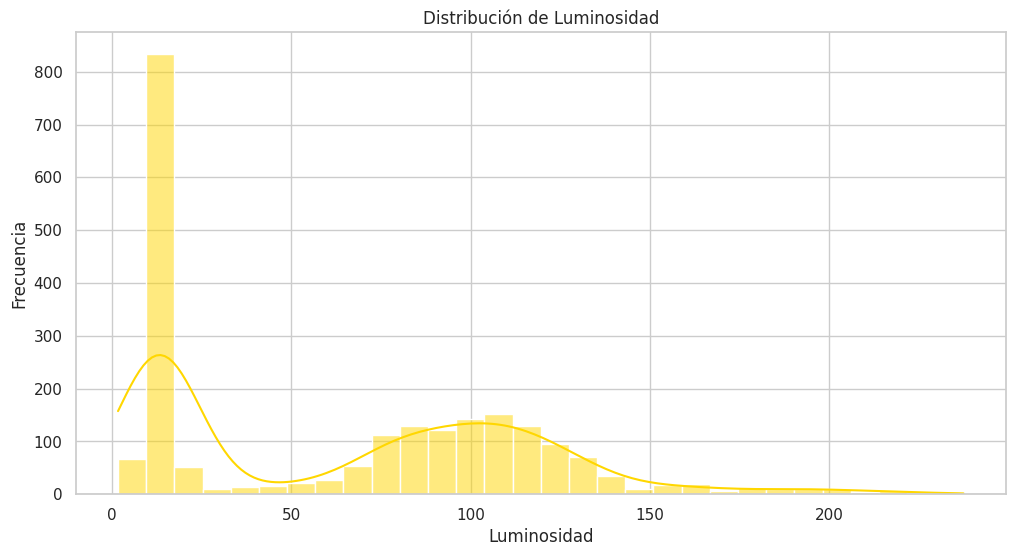

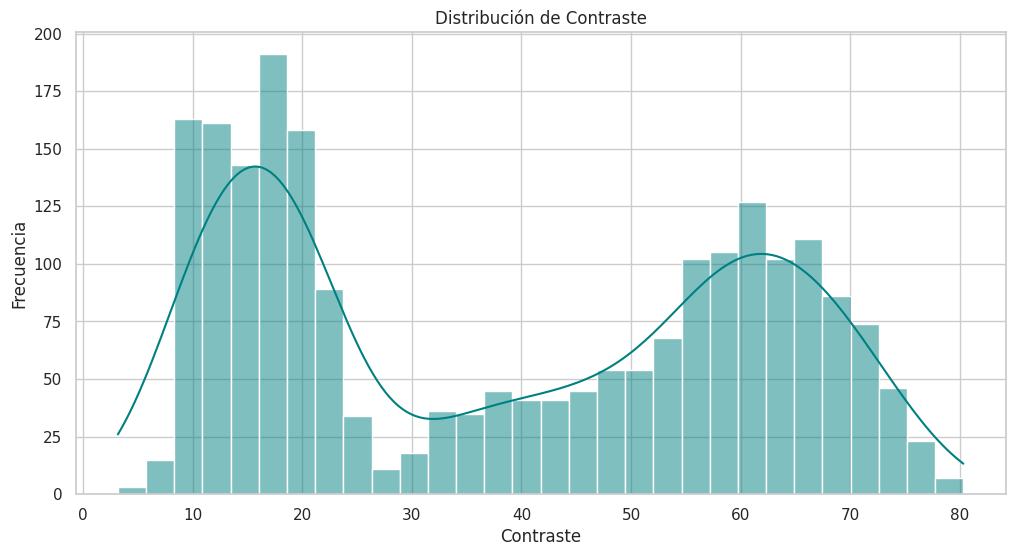

In [75]:
# Graficar la distribución de Luminosidad
plt.figure(figsize=(12, 6))
sns.histplot(df['Luminosity'], bins=30, kde=True, color='gold')
plt.title('Distribución de Luminosidad')
plt.xlabel('Luminosidad')
plt.ylabel('Frecuencia')
plt.show()

# Graficar la distribución de Contraste
plt.figure(figsize=(12, 6))
sns.histplot(df['Contrast'], bins=30, kde=True, color='teal')
plt.title('Distribución de Contraste')
plt.xlabel('Contraste')
plt.ylabel('Frecuencia')
plt.show()


### Vemos el promedio de luminosidad en el dataset

In [76]:
print(df['Luminosity'].describe())


count    2188.000000
mean       64.954606
std        51.597062
min         1.786648
25%        13.665167
50%        72.637358
75%       106.239983
max       237.350466
Name: Luminosity, dtype: float64


### Dividimos el dataset en cuantiles para tener 25%, 50% y 75%

In [77]:
# Calcular los cuartiles de la luminosidad
q1 = df['Luminosity'].quantile(0.25)
q3 = df['Luminosity'].quantile(0.75)
median_luminosity = df['Luminosity'].median()

print(f"Q1 (25%): {q1}")
print(f"Mediana (50%): {median_luminosity}")
print(f"Q3 (75%): {q3}")


Q1 (25%): 13.665166859567899
Mediana (50%): 72.63735797646605
Q3 (75%): 106.23998336226852


### Filtramos las imágenes según la cateroría de luminosidad, q1, q2 y q3

In [78]:
# Definir los rangos de luminosidad
luminosity_low_max = q1
luminosity_average_min = q1
luminosity_average_max = q3
luminosity_high_min = q3

# Filtrar imágenes por categoría
low_luminosity_df = df[df['Luminosity'] <= luminosity_low_max]
average_luminosity_df = df[(df['Luminosity'] > luminosity_average_min) & (df['Luminosity'] <= luminosity_average_max)]
high_luminosity_df = df[df['Luminosity'] > luminosity_high_min]

# Verificar el número de imágenes en cada categoría
print(f"Número de imágenes con baja luminosidad: {len(low_luminosity_df)}")
print(f"Número de imágenes con luminosidad promedio: {len(average_luminosity_df)}")
print(f"Número de imágenes con alta luminosidad: {len(high_luminosity_df)}")


Número de imágenes con baja luminosidad: 547
Número de imágenes con luminosidad promedio: 1094
Número de imágenes con alta luminosidad: 547


### Función para descargar una imagen del s3 según la key

In [79]:
def download_image_from_s3(s3_client, bucket, key):
    try:
        response = s3_client.get_object(Bucket=bucket, Key=key)
        image_data = response['Body'].read()
        image = Image.open(BytesIO(image_data)).convert('RGB')  # Convertir a RGB si es necesario
        return image
    except Exception as e:
        print(f"Error al descargar o procesar la imagen {key}: {e}")
        return None


### Función para descargar 3 imágenes del s3 según las 3 categorías

In [80]:
# Función para seleccionar una imagen al azar de un DataFrame
def select_random_image(df_category):
    if df_category.empty:
        print("No hay imágenes en esta categoría.")
        return None
    return df_category.sample(n=1).iloc[0]

# Seleccionar una imagen de cada categoría
image_low = select_random_image(low_luminosity_df)
image_average = select_random_image(average_luminosity_df)
image_high = select_random_image(high_luminosity_df)


### Descargamos las 3 imágenes

In [81]:
# Inicializar el cliente de S3
s3 = boto3.client('s3')

# Descargar las imágenes
image_low_pil = download_image_from_s3(s3, BUCKET_NAME, image_low['Key']) if image_low is not None else None
image_average_pil = download_image_from_s3(s3, BUCKET_NAME, image_average['Key']) if image_average is not None else None
image_high_pil = download_image_from_s3(s3, BUCKET_NAME, image_high['Key']) if image_high is not None else None


### Mostramos las 3 imágenes, una para cada nivel de luminosidad

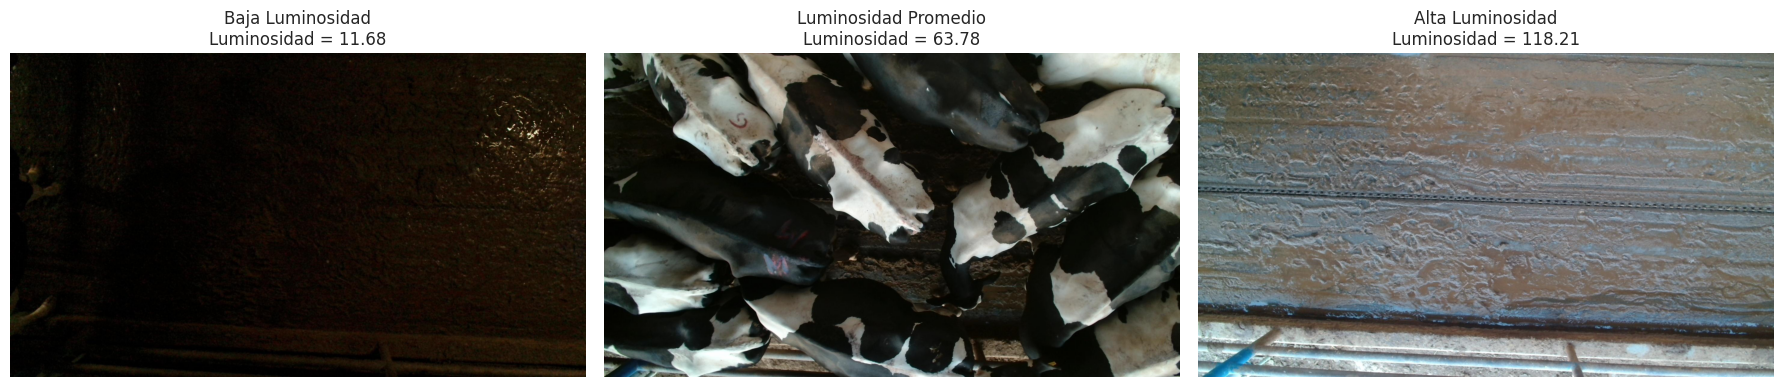

In [85]:
# Crear una figura con 3 subplots
plt.figure(figsize=(18, 6))

# Imagen de baja luminosidad
plt.subplot(1, 3, 1)
if image_low_pil:
    plt.imshow(image_low_pil)
    plt.title(f'Baja Luminosidad\nLuminosidad = {image_low["Luminosity"]:.2f}')
else:
    plt.text(0.5, 0.5, 'No hay imagen', horizontalalignment='center', verticalalignment='center')
plt.axis('off')

# Imagen de luminosidad promedio
plt.subplot(1, 3, 2)
if image_average_pil:
    plt.imshow(image_average_pil)
    plt.title(f'Luminosidad Promedio\nLuminosidad = {image_average["Luminosity"]:.2f}')
else:
    plt.text(0.5, 0.5, 'No hay imagen', horizontalalignment='center', verticalalignment='center')
plt.axis('off')

# Imagen de alta luminosidad
plt.subplot(1, 3, 3)
if image_high_pil:
    plt.imshow(image_high_pil)
    plt.title(f'Alta Luminosidad\nLuminosidad = {image_high["Luminosity"]:.2f}')
else:
    plt.text(0.5, 0.5, 'No hay imagen', horizontalalignment='center', verticalalignment='center')
plt.axis('off')

plt.tight_layout()
plt.show()